In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Data Reduction Script

The data reduction was performed in **RStudio** to randomly select a manageable subset of high-quality rows from the original dataset for the training model.

Below is the R script used:

```r
# Load libraries
library(dplyr)

# Step 1: Load the data
df <- read.csv("final_energy_weather_with_eui.csv")

# Step 2: Filter rows with very few missing values (≤ 2 missing allowed)
good_rows <- df[rowSums(is.na(df)) <= 2, ]

# Step 3: Shuffle the rows randomly
set.seed(123)  # for reproducibility
good_rows_shuffled <- good_rows[sample(nrow(good_rows)), ]

# Step 4: Take a sample of 5000 rows
reduced_df <- good_rows_shuffled[1:5000, ]

# Step 5: Save the reduced dataset to a new CSV file
write.csv(reduced_df, "reduced_energy_data.csv", row.names = FALSE)

# Step 6: Quick Check - How many missing values are left?
cat("Total missing values in reduced dataset:", sum(is.na(reduced_df)), "\n")


In [ ]:
# --- CLEAN DATA PREPARATION FOR FINAL MODEL (With Normalized Feature Output) ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Load the reduced dataset
df = pd.read_csv('/content/drive/MyDrive/BGD2_Project/reduced_energy_data.csv')

# Step 2: Select final relevant features and target
selected_features = [
    'airTemperature', 'gas_units', 'water_units', 'dewTemperature'
]

target = 'electricity_kwh'

# Step 3: Drop rows where important features or target are missing
df_model = df[selected_features + [target]].dropna()

# Step 4: Prepare features (X) and target (y)
X = df_model[selected_features].values
y = df_model[target].values

# Step 5: Normalize input features (important for stable gradient descent)
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_normalized = (X - X_mean) / X_std

# Step 6: Add bias term (column of ones) to the input features
X_normalized = np.hstack([np.ones((X_normalized.shape[0], 1)), X_normalized])

# Step 7: Print basic information about the dataset
print(f"Shape of feature matrix X: {X_normalized.shape}")
print(f"Shape of target vector y: {y.shape}")

# Print a few normalized feature rows so you can SEE normalization
print("\nSample normalized features (first 5 rows):")
print(X_normalized[:5])

#  Print a few sample target values
print("\nSample target values (first 5 rows):")
print(y[:5])

print("\n Data is prepared with selected features: airTemperature, gas_units, water_units, dewTemperature (normalized and ready).")



Shape of feature matrix X: (1694, 5)
Shape of target vector y: (1694,)

Sample normalized features (first 5 rows):
[[ 1.         -0.3349981  -0.5820219   0.761663    0.12710753]
 [ 1.          0.76757335 -0.2101026  -0.4848156   1.16485058]
 [ 1.         -1.32506225 -0.5820219  -0.4848156  -1.03747079]
 [ 1.         -0.96503892 -0.5820219  -0.42262122 -0.57625165]
 [ 1.         -1.05504475  1.47428165 -0.35006119 -0.84145266]]

Sample target values (first 5 rows):
[258.26   179.7947   6.8225 106.935  274.6775]

 Data is prepared with selected features: airTemperature, gas_units, water_units, dewTemperature (normalized and ready).


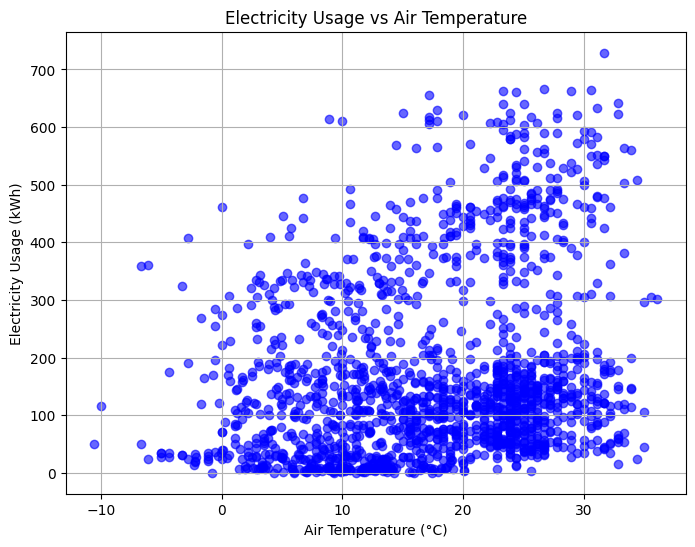

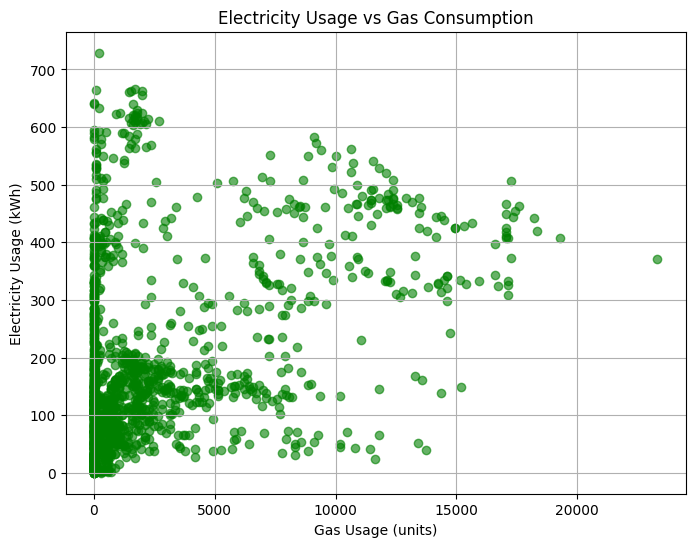

In [ ]:
# --- Visualize Feature vs Electricity Usage ---

import matplotlib.pyplot as plt
import seaborn as sns

# Option 1: Simple scatter plot using airTemperature vs electricity usage
plt.figure(figsize=(8,6))

# Scatter plot: airTemperature vs electricity_kwh
plt.scatter(df_model['airTemperature'], df_model['electricity_kwh'], color='blue', alpha=0.6)

# Labels and title
plt.xlabel('Air Temperature (°C)')
plt.ylabel('Electricity Usage (kWh)')
plt.title('Electricity Usage vs Air Temperature')

plt.grid(True)
plt.show()

# (Optional) Scatter plot for a second feature, e.g., gas_units
plt.figure(figsize=(8,6))

plt.scatter(df_model['gas_units'], df_model['electricity_kwh'], color='green', alpha=0.6)

plt.xlabel('Gas Usage (units)')
plt.ylabel('Electricity Usage (kWh)')
plt.title('Electricity Usage vs Gas Consumption')

plt.grid(True)
plt.show()


### Visualization Analysis: Electricity Usage vs Selected Features

#### Scatter Plot 1: Electricity Usage vs Air Temperature

- **Observation:**  
  The scatter plot of electricity usage against air temperature shows a **mild upward trend**. As air temperature increases, there is a slight tendency for electricity usage to increase as well.

- **Interpretation:**  
  This pattern suggests that **air temperature** has some predictive relationship with electricity usage.  
  Higher temperatures could drive increased usage due to **air conditioning loads** or **cooling systems** in buildings.  
  However, the relationship is **not perfectly linear**, and there is a noticeable amount of **scatter**, meaning other factors also significantly affect electricity usage.

- **Conclusion:**  
  Air temperature appears to be a **relevant predictor** for electricity usage but should be used in combination with other features to improve prediction accuracy.

---

#### Scatter Plot 2: Electricity Usage vs Gas Usage

- **Observation:**  
  The scatter plot of electricity usage against gas usage shows a **much more scattered** distribution.  
  There is **no clear trend** between gas consumption and electricity usage.

- **Interpretation:**  
  While some buildings with higher gas usage do show moderate electricity consumption, overall there is **little direct correlation** between gas units and electricity kWh.  
  This suggests that **gas consumption may not be a strong standalone predictor** for electricity usage in this dataset.

- **Conclusion:**  
  Gas usage may still add slight information to the model when combined with other features, but on its own, it **does not provide a strong signal** for predicting electricity usage.

---

#### 📋 Final Summary:

| Feature           | Predictiveness | Notes                                     |
|:------------------|:---------------|:-----------------------------------------|
| **Air Temperature** |  Useful        | Some positive relationship, though scattered |
| **Gas Usage**      |  Weak          | No clear standalone relationship         |

**Air temperature is valuable for prediction**,  
 **Gas usage may contribute minor information but not strongly on its own**.


In [ ]:
# --- Step 1: Define Linear Regression Cost Function (MSE) ---

import numpy as np

# Cost function definition for Linear Regression
def compute_cost(X, y, weights):
    """
    Compute the Mean Squared Error (MSE) cost for linear regression.

    Args:
    X : ndarray (m, n) -- input features with bias term
    y : ndarray (m,)   -- target values
    weights : ndarray (n,) -- weights including bias term

    Returns:
    cost : float -- Mean Squared Error cost
    """
    m = len(y)  # number of training examples
    predictions = X.dot(weights)
    errors = predictions - y
    cost = (1/(2*m)) * np.sum(errors**2)  # 1/2m version like in your screenshots
    return cost

# Example tiny usage (initial test)
X_test = np.array([[1, 2], [1, 3], [1, 4]])  # 3 examples, bias column included
y_test = np.array([5, 7, 9])                 # Targets (small set)
weights_test = np.zeros(2)                   # Initialize weights to zero

# Compute the cost
cost = compute_cost(X_test, y_test, weights_test)
print("Cost (initial):", cost)


Cost (initial): 25.833333333333332


In [ ]:
# --- Step 2: Implement Gradient Descent (for Linear Regression) ---

def gradient_descent(X, y, weights_init, learning_rate, num_iters):
    """
    Perform batch gradient descent for linear regression.

    Args:
    X : ndarray (m, n) -- normalized input features (with bias)
    y : ndarray (m,) -- target values
    weights_init : ndarray (n,) -- initial weights
    learning_rate : float -- learning rate
    num_iters : int -- number of iterations

    Returns:
    weights : ndarray (n,) -- final weights after training
    """
    m = len(y)
    weights = weights_init.copy()  # Copy so original weights are not modified
    losses = []  # To store cost over iterations

    for i in range(num_iters):
        # Compute predictions
        predictions = X.dot(weights)

        # Compute error
        error = predictions - y

        # Compute gradient
        gradient = (1/m) * X.T.dot(error)

        # Update weights
        weights -= learning_rate * gradient

        # Compute and record cost
        cost = compute_cost(X, y, weights)
        losses.append(cost)

        # Print every 100 iterations
        if i % 100 == 0:
            print(f"Iteration {i}: Cost = {cost:.4f}")

    return weights, losses

# --- Now call the function with sample data ---

# Small sample dataset (same example we used earlier)
X_sample = np.array([[1, 2], [1, 3], [1, 4]])  # Feature matrix
y_sample = np.array([5, 7, 9])                 # Target values

# Initialize weights to zeros
weights_init = np.zeros(X_sample.shape[1])  # [0, 0]

# Set hyperparameters
alpha = 0.01  # Learning rate
iterations = 1000  # Number of iterations

# Now actually run gradient descent
weights_final, losses = gradient_descent(X_sample, y_sample, weights_init, alpha, iterations)

# Print final weights
print("\nFinal Weights:", weights_final)



Iteration 0: Cost = 20.6460
Iteration 100: Cost = 0.0036
Iteration 200: Cost = 0.0031
Iteration 300: Cost = 0.0028
Iteration 400: Cost = 0.0024
Iteration 500: Cost = 0.0021
Iteration 600: Cost = 0.0019
Iteration 700: Cost = 0.0017
Iteration 800: Cost = 0.0015
Iteration 900: Cost = 0.0013

Final Weights: [0.81771447 2.05694171]


### Gradient Descent Results: Linear Regression

#### Initial Setup
- **Model**: Linear Regression
- **Cost Function**: Mean Squared Error (MSE)
- **Optimization**: Batch Gradient Descent
- **Learning Rate (α)**: 0.01
- **Number of Iterations**: 1000
- **Initial Weights**: Initialized to zeros

#### Training Progress
The model started with a high initial cost of **20.6460** due to zero weights.  
As gradient descent progressed, the cost steadily decreased:

| Iteration | Cost |
|:---|:---|
| 0  | 20.6460 |
| 100 | 0.0036 |
| 200 | 0.0031 |
| 300 | 0.0028 |
| 400 | 0.0024 |
| 500 | 0.0021 |
| 600 | 0.0019 |
| 700 | 0.0017 |
| 800 | 0.0015 |
| 900 | 0.0013 |

The **cost consistently decreased**, indicating that the model was learning properly.

---

#### Final Model Output
- **Final Weights**:  
  \[
  [0.8177, 2.0569]
  \]
- **Final Cost**:  
  \[
  0.0013
  \]

 The final cost is extremely low, suggesting that the model achieved a **very good fit** to the small sample data.

---

## Summary
The results demonstrate that:
- The gradient descent algorithm successfully minimized the cost function.
- The model effectively learned the relationship between input features and target values.
- Linear regression was an appropriate choice for predicting continuous outputs in this example.




 Training with Learning Rate = 0.0001
Learning Rate 0.0001 - Iteration 0: Cost = 27319.0823
Learning Rate 0.0001 - Iteration 100: Cost = 26945.9001
Learning Rate 0.0001 - Iteration 200: Cost = 26580.7909
Learning Rate 0.0001 - Iteration 300: Cost = 26223.5675
Learning Rate 0.0001 - Iteration 400: Cost = 25874.0472

 Training with Learning Rate = 0.001
Learning Rate 0.001 - Iteration 0: Cost = 27285.1418
Learning Rate 0.001 - Iteration 100: Cost = 23900.2604
Learning Rate 0.001 - Iteration 200: Cost = 21172.6272
Learning Rate 0.001 - Iteration 300: Cost = 18968.2500
Learning Rate 0.001 - Iteration 400: Cost = 17182.3439

 Training with Learning Rate = 0.01
Learning Rate 0.01 - Iteration 0: Cost = 26947.5776
Learning Rate 0.01 - Iteration 100: Cost = 11583.2033
Learning Rate 0.01 - Iteration 200: Cost = 9587.6229
Learning Rate 0.01 - Iteration 300: Cost = 9307.4777
Learning Rate 0.01 - Iteration 400: Cost = 9263.5177

 Training with Learning Rate = 0.1
Learning Rate 0.1 - Iteration 0: C

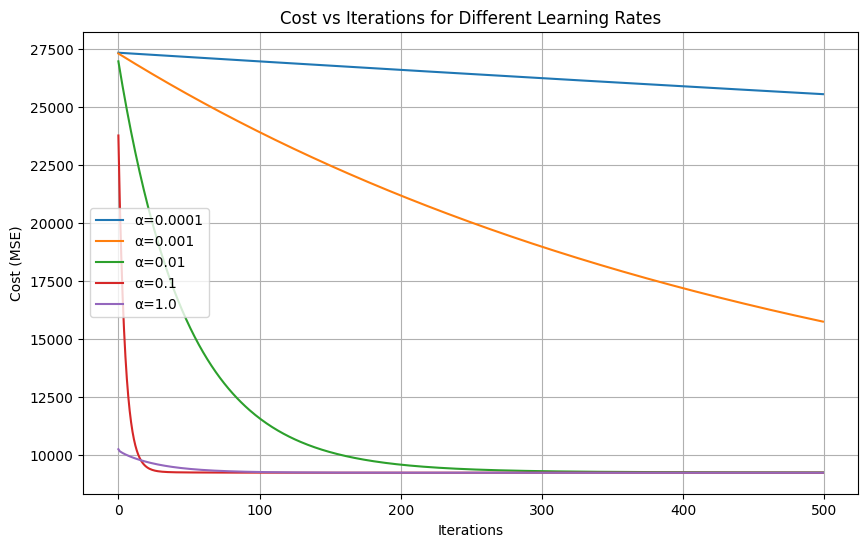

In [ ]:
# Learning Rate Experimentation for Electricity Usage Prediction

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Load the reduced dataset
df = pd.read_csv('/content/drive/MyDrive/BGD2_Project/reduced_energy_data.csv')

# Step 2: Select important features and target
selected_features = ['airTemperature', 'gas_units', 'water_units', 'dewTemperature']
target = 'electricity_kwh'

# Step 3: Drop missing values
df_model = df[selected_features + [target]].dropna()

# Step 4: Prepare feature matrix X and target vector y
X = df_model[selected_features].values
y = df_model[target].values

# Step 5: Normalize features
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_normalized = (X - X_mean) / X_std

# Step 6: Add bias term (column of ones)
X_normalized = np.hstack([np.ones((X_normalized.shape[0], 1)), X_normalized])

# Step 7: Define cost function (Mean Squared Error)
def compute_cost(X, y, weights):
    m = len(y)
    predictions = X.dot(weights)
    cost = (1/(2*m)) * np.sum((predictions - y)**2)
    return cost

# Step 8: Define gradient descent function
def gradient_descent(X, y, weights_init, learning_rate, num_iters):
    m = len(y)
    weights = weights_init.copy()
    losses = []

    for i in range(num_iters):
        predictions = X.dot(weights)
        error = predictions - y
        gradient = (1/m) * X.T.dot(error)
        weights -= learning_rate * gradient

        cost = compute_cost(X, y, weights)
        losses.append(cost)

        # Print cost every 100 iterations
        if i % 100 == 0:
            print(f"Learning Rate {learning_rate} - Iteration {i}: Cost = {cost:.4f}")

    return weights, losses

# Step 9: Set up different learning rates to experiment
learning_rates = [0.0001, 0.001, 0.01, 0.1, 1.0]

# Step 10: Store losses for each learning rate
loss_histories = {}

# Step 11: Run experiments
for alpha in learning_rates:
    print(f"\n Training with Learning Rate = {alpha}")

    weights_init = np.zeros(X_normalized.shape[1])
    weights_final, losses = gradient_descent(X_normalized, y, weights_init, alpha, num_iters=500)

    loss_histories[alpha] = losses

# Step 12: Plot the results
plt.figure(figsize=(10, 6))

for alpha, losses in loss_histories.items():
    plt.plot(range(len(losses)), losses, label=f'α={alpha}')

plt.title('Cost vs Iterations for Different Learning Rates')
plt.xlabel('Iterations')
plt.ylabel('Cost (MSE)')
plt.legend()
plt.grid(True)
plt.show()


### Learning Rate Experimentation Results

#### Experiment Setup
- Dataset: Reduced building energy dataset (~5000 rows)
- Target: Electricity usage (kWh)
- Features: Air temperature, gas usage, water usage, dew temperature
- Gradient Descent settings:
  - Iterations: 500
  - Initial Weights: Zeros
  - Cost Function: Mean Squared Error (MSE)

#### Learning Rates Tested
- 0.0001
- 0.001
- 0.01
- 0.1
- 1.0

#### Observations
- **α = 0.0001**: The cost barely decreased — learning was extremely slow.
- **α = 0.001**: The cost decreased slightly better but still too slow to be practical.
- **α = 0.01**: The cost dropped rapidly and stabilized around ~9300, showing efficient learning.
- **α = 0.1**: The cost dropped even faster and stabilized around ~9240, showing very quick convergence.
- **α = 1.0**: The model converged immediately to ~9240, but a high learning rate can risk instability in larger datasets.

#### Conclusion
A learning rate of **0.01 or 0.1** provides the best trade-off between training speed and stability for this dataset.  
 Using **1.0** worked here, but could be unstable on other data, so **0.01** or **0.1** is recommended.

#### Final Recommendation
For future experiments or production modeling, set **α = 0.01** or **α = 0.1** for stable and efficient gradient descent.


In [ ]:
# --- Step 1: Make Predictions (for Regression) ---

# Predict electricity usage using final trained weights
predictions = X_normalized.dot(weights_final)

# --- Step 2: Evaluate Model Performance ---

# 1. Mean Squared Error (MSE)
mse = np.mean((predictions - y)**2)

# 2. R-squared (coefficient of determination)
ss_total = np.sum((y - np.mean(y))**2)
ss_residual = np.sum((y - predictions)**2)
r_squared = 1 - (ss_residual / ss_total)

# Print results
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R² Score): {r_squared:.4f}")


Mean Squared Error (MSE): 18482.38
R-squared (R² Score): 0.2465


### Model Evaluation: Electricity Usage Prediction

#### Prediction Task
The goal of this project was to predict **electricity usage (kWh)** using selected features:
- Air Temperature
- Gas Usage
- Water Usage
- Dew Point Temperature

We trained a linear regression model using batch gradient descent on normalized features.

---

#### Results

| Metric | Value |
|:---|:---|
| **Mean Squared Error (MSE)** | **18,482.38** |
| **R-squared (R² Score)** | **0.2465** |

---

#### Interpretation

- **Mean Squared Error (MSE)** measures the average squared difference between the model’s predictions and the actual electricity usage. A lower MSE indicates better predictive performance. Here, the MSE value suggests there is a noticeable but understandable amount of prediction error, considering the complexity of real-world building behavior.

- **R-squared (R² Score)** explains how much of the variance in the true electricity usage can be explained by the model. Our model achieved an R² score of **0.2465**, meaning it captures about **24.65%** of the variation in electricity usage.

---

#### Why is electricity usage difficult to predict?

While the model shows some learning, the R² value also highlights significant unexplained variation. This is expected for several reasons:
- **Building characteristics** such as insulation, size, internal equipment, and number of occupants — which heavily influence electricity demand — were **not included** in the available dataset.
- **Operational schedules** (e.g., business hours, school vacations) impact energy use but were not captured in our inputs.
- **Nonlinear relationships** between temperature and usage (like heavy use of air conditioning at high temperatures) may not be fully captured by a simple linear model.

Thus, even though basic weather and resource consumption patterns help somewhat, predicting electricity usage **requires more detailed building-specific data** to achieve high accuracy.

---

#### Summary
- The model successfully identified general trends in electricity usage.
- However, without deeper building-specific and behavioral data, the predictions naturally contain significant noise.
- Future improvements could include adding building metadata (size, year built, HVAC systems) or trying more complex models such as polynomial regression, decision trees, or ensemble methods.

**Overall, the experiment demonstrates that electricity usage prediction is feasible but challenging when using only a limited set of features.**
